# Testing photobleaching model 

In [6]:
import numpy as np
import pandas as pd
import bokeh.io
import bokeh.plotting
import mscl_utils as mscl
import scipy.signal
import mscl_mcmc as msmc
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
%matplotlib inline
bokeh.io.output_notebook()

Loading BokehJS ...

In this notebook, I will describe a heirarchical statistical model for photobleaching and test it out on simulated data. The model developed here is used to correct for signal loss due to photobleaching during the dilution experiment.  

## The problem 



$$
I(t) = \beta_0 + I_0 \exp\left[{-t \over \tau}\right]
$$

In [72]:
# Set the simulation parameters
n_cells = 5 
time = np.arange(0, 500, 1)
beta_seed = np.random.normal(loc=1000, scale=20, size=n_cells)
I0_seed = np.random.normal(loc=8000, scale=4000, size=n_cells)
tau_seed = np.random.normal(loc=100, scale=10, size=n_cells)
noise = np.random.normal(loc=0, scale=250, size=n_cells)

# Perform the simulation and store as a dataframe.
df = pd.DataFrame([], columns=['cell_number', 'I_t', 'time'])
for i in range(n_cells):
    sim = beta_seed[i] + I0_seed[i]* np.exp(-time/tau_seed[i]) + np.random.normal(loc=0, scale=500, size=len(time))
    _df = pd.DataFrame([sim, time]).T
    _df.columns = ['I_t', 'time'] 
    _df.insert(0, 'cell_number', i) 
    df = df.append(_df, ignore_index=True)

As is typically the case, we can look at our simulated data to see if it makes sense. 

In [78]:
p = mscl.bokeh_boiler(width=700, height=600, x_axis_label='[time]',
                      y_axis_label='intensity')

# Plot each trace individually
grouped = df.groupby('cell_number')
for g, d in grouped:
    p.line(d['time'], d['I_t'], color='slategray', alpha=0.5, legend='simulated data')
    p.circle(d['time'], d['I_t'], color='slategray', alpha=0.5) 
bokeh.io.show(p)

The data looks as is expected. Note the large degree of noise in the measurement. To get a better sense of what a single cell would look like, we can take a look at a single trace

In [79]:
# Look at just one trace
cell_ind = 3
single_cell = df.loc[df['cell_number']==cell_ind]

# Compute the "true" curve without the noise.
time_range = np.linspace(0, 500, 1000)
true_trace = beta_seed[cell_ind] + I0_seed[cell_ind] *\
                np.exp(-time_range / tau_seed[cell_ind])

# Set up the figure axis.
p = mscl.bokeh_boiler(width=700, height=600,
                      x_axis_label='[time]', y_axis_label='intensity')

# Plot the data and the true curve.
p.circle(single_cell['time'], single_cell['I_t'], color='slategray', alpha=0.5,
        legend='simulated data')
p.line(single_cell['time'], single_cell['I_t'], color='slategray', alpha=0.5)
p.line(time_range, true_trace, color='tomato', line_width=2, legend='true bleaching curve')

# Show it in the notebook.
bokeh.io.show(p)

Since our simulated data passes the smell test, we can take a pass at inferring the relevant parameter values.  

## Approach I: Fitting to an average trajectory

There are three "reasonable" approaches to take for this experiment. The first is to compute the average trace from all cells and estimate the parameters to that average. 


##  Approach II: Fitting to individual trajectories

In [80]:
with pm.Model() as model:
    # Define the priors.
    beta = pm.Uniform('beta', lower=0, upper=1E6)
    I0 = pm.Uniform('I0', lower=0, upper=1E6)
    tau = msmc.Jeffreys('tau', lower=1E-3, upper=1E3)
    
    # Compute the expected value.
    time = single_cell['time'].values
    theo = beta + I0 * tt.exp(-time / tau)
    
    # Define the likelihood.
    like = msmc.MarginalizedNormal('like', mu=theo, observed=single_cell['I_t'].values)
    
    # Sample
    trace = pm.sample(draws=1000, tune=10000, njobs=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 11000/11000 [00:26<00:00, 407.57it/s]


{'beta': 1.0000723218534198, 'I0': 1.0007114916855422, 'tau': 0.99987409460007204}


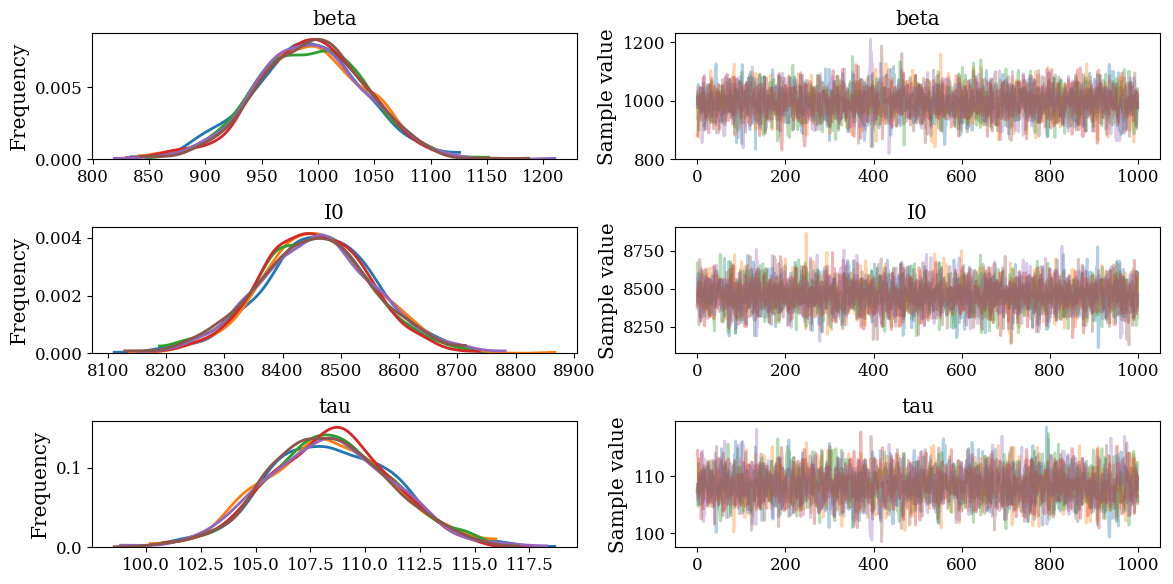

In [40]:
# Test for convergence.
print(pm.gelman_rubin(trace))
_ = pm.traceplot(trace)

In [81]:
# Compute the modes and plot the fit. 
mcmc_df = pm.trace_to_dataframe(trace)
mcmc_df['logp'] = pm.stats._log_post_trace(trace, model).sum(axis=1)
ind = np.argmax(mcmc_df['logp'])
modes = mcmc_df.iloc[ind]

In [83]:
p = mscl.bokeh_boiler(width=800, height=700, x_axis_label='[time]',
                     y_axis_label='signal')

# Plot the data.
p.circle(single_cell['time'], single_cell['I_t'], color='slategray', legend='simulated data')

# Compute the representative trace
frames = np.linspace(0, 500, 500)
def exp_decay(modes, frames):
    beta, I0, tau = modes
    fit = beta + I0 * np.exp(-frames / tau)
    return fit

fit = exp_decay((modes['beta'], modes['I0'], modes['tau']), frames)

p.line(frames, fit, color='dodgerblue', legend='fit from MCMC',
      line_width=2)
bokeh.io.show(p)

## Approach III: A heirarchical model

In [89]:
# Make a new dataframe with some smoothed data included.
with pm.Model() as model:
    # Set the top level hyperpriors.
    tau_mu = pm.Uniform('tau_mu', lower=1E-3, upper=1E3)
    tau_sig = msmc.Jeffreys('tau_sig', lower=1E-3, upper=1E3)
    beta_mu = pm.Normal('beta_mu', mu=1000, sd=100)
    beta_sig = msmc.Jeffreys('beta_sig', lower=1E-3, upper=1E6)

    # Set the lower level priors.
    tau = pm.Normal('tau', mu=tau_mu, sd=tau_sig, shape=n_cells)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sig, shape=n_cells)
    I0 = pm.Normal('I0', mu=1000, sd=100, shape=n_cells)
    
    # Get the ID's and other observables
    ids = df['cell_number'].values.astype(int)
    time = df['time'].values.astype(float)
    obs = df['I_t'].values.astype(float)
    
    # Compute the expected value.
    theo = beta[ids] + I0[ids] * tt.exp(-time / tau[ids])
    
    # Set the likelihood.
    like = msmc.MarginalizedNormal('like', mu=theo, observed=obs) 
    
    # Sample.
    trace = pm.sample(draws=5000, tune=10000, njobs=4, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 29,113:  16%|█▌        | 31812/200000 [00:24<02:08, 1312.70it/s]   
Convergence archived at 31900
Interrupted at 31,899 [15%]: Average Loss = 36,458
 88%|████████▊ | 13259/15000 [42:34<05:35,  5.19it/s]/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.659928065496, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 434 diverging samples after tuning. If increasing 

{'beta_mu': 1.0095254609279467, 'tau': array([ 1.00679468,  1.00486252,  1.00659317,  1.00609551,  1.00590585]), 'beta': array([ 1.00227158,  1.00758533,  1.0034438 ,  1.0023226 ,  1.00760553]), 'I0': array([ 1.00185465,  1.00711855,  1.00540855,  1.00311218,  1.00162694]), 'tau_mu': 1.0064189719470849, 'tau_sig': 1.0025076383304652, 'beta_sig': 1.0019427977444881}


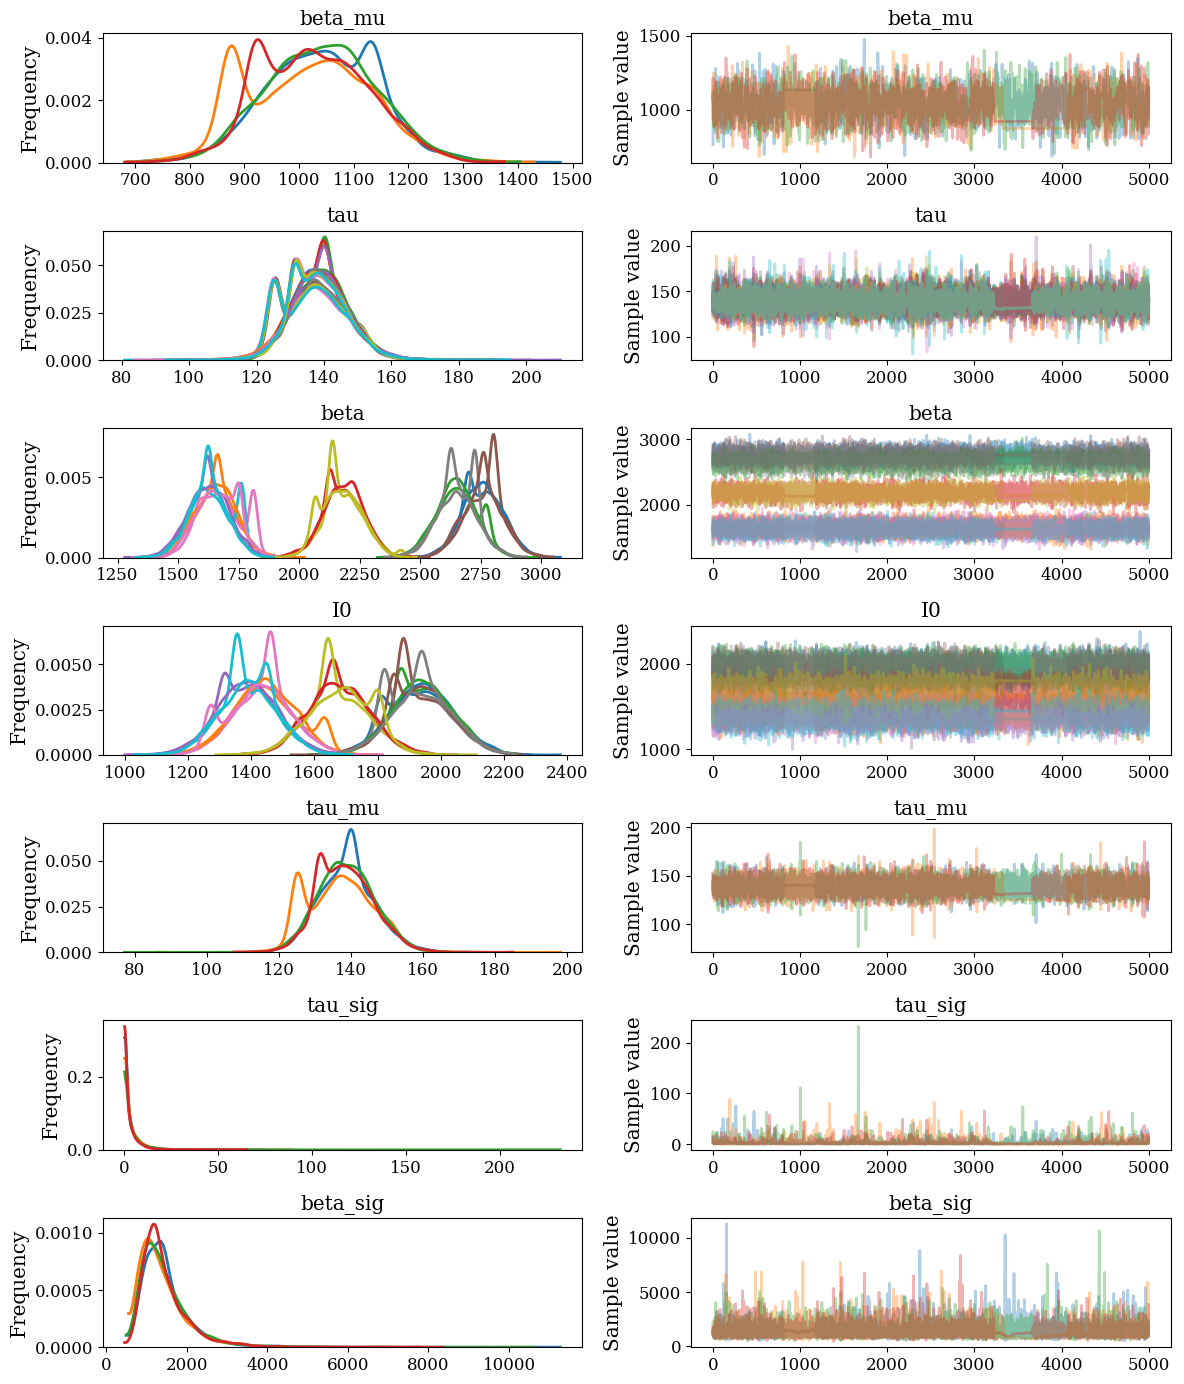

In [90]:
# Test for convergence.
print(pm.gelman_rubin(trace))
_ = pm.traceplot(trace)

In [91]:
# Compute the modes.
hyper_df = pm.trace_to_dataframe(trace)
hyper_df['logp'] = pm.stats._log_post_trace(trace, model).sum(axis=1)
ind = np.argmax(hyper_df['logp'])[0]
hyper_modes = hyper_df.iloc[ind]

TypeError: 'int' object is not subscriptable

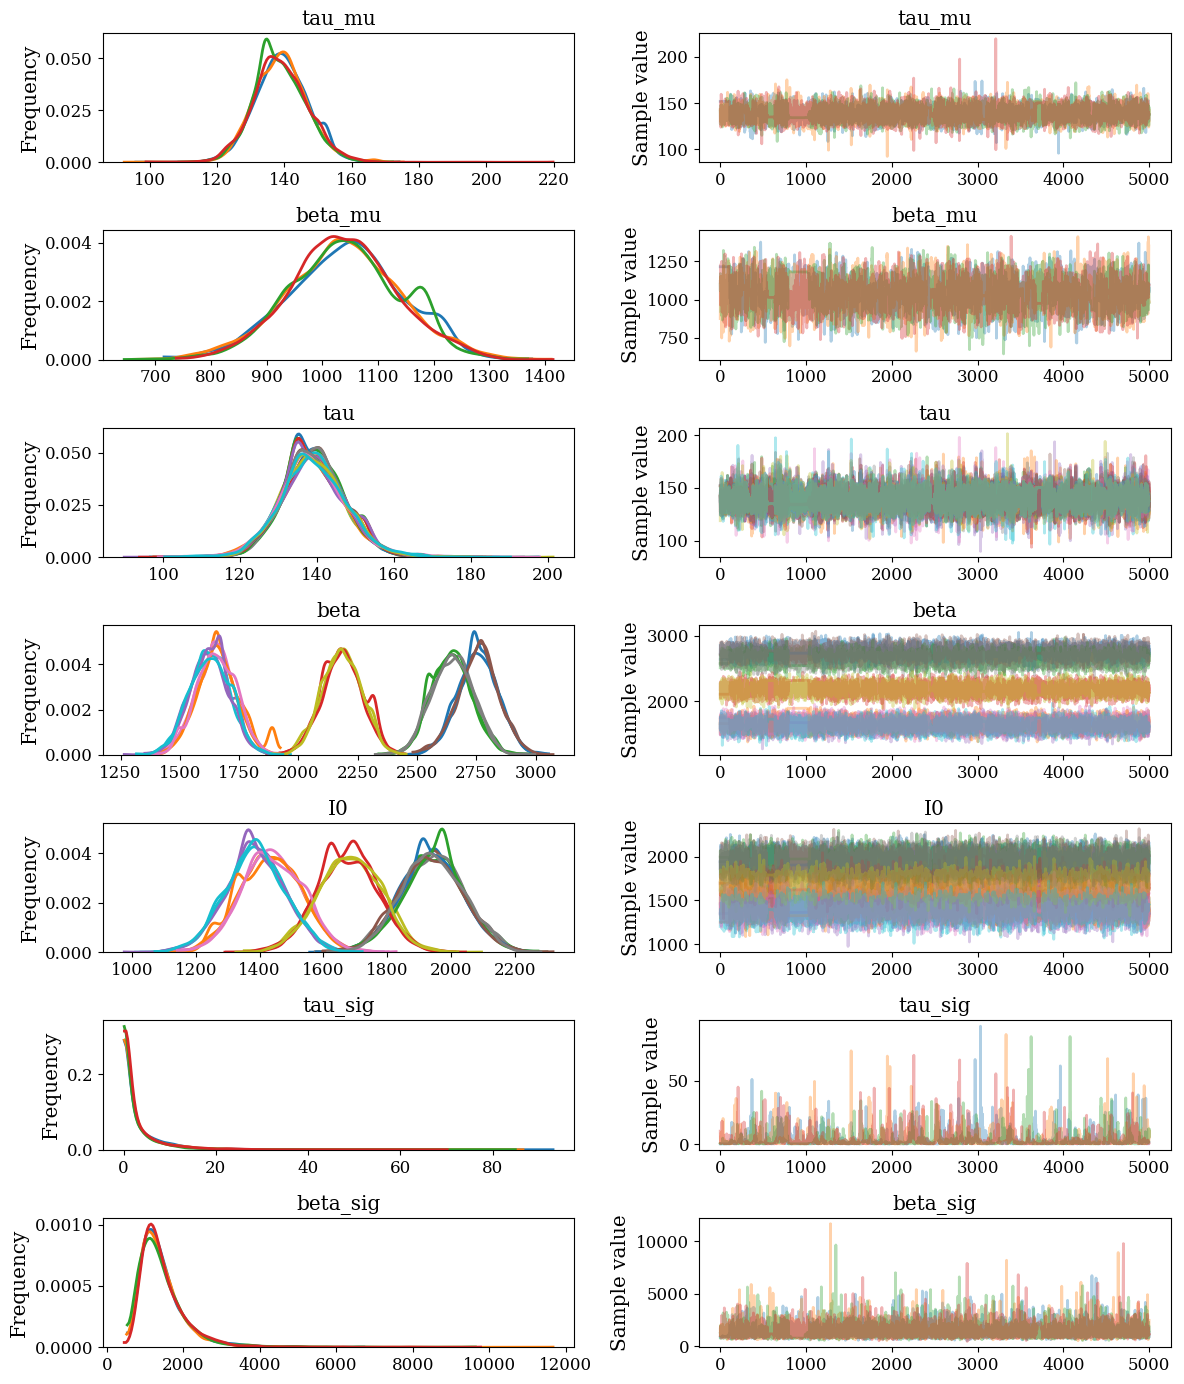

In [87]:
# Plot the theo.
